# Logistic Regression
- Key Tasks:
    - Feature Engineering
    - Data Preparation
    - Build a model
    - Account for imbalance
    - Analysis and Recommendation

- Feature Engineering:
    - In machine learning, we refer to the measurable characteristics of the object that we are trying to analyze as features. You have developed multiple featuers through your analysis in previous projects. Consider any new features that you might develop on your own, explaining why you chose those features.
        - Hint 1: Is the direct manager's satisfaction important?
        - Hint 2: Is the number of 2/5 or below responses important?
        - what other feature ideas do you have?
    
- Data Preparation:
    - Normalize your features
    - Split your dataset into training and validation set, ignoring the imbalance of the target variable for now.

- Build a Model:
    - Add and remove features to achieve the best metrics you can. Focus on the following.
        - AUC, accuracy, precision and recall.
        - Plot the ROC Curve
        - How stable is the model out of sample?

- Account for imbalance:
    - The dataset has an inherent imbalance in the target class (thankfully, we don't see 50% of people turning-over after six months).
        - Run a model that applies weights to compensate for the imbalance
        - Measure the AUC, accuracy, precision and recall, and plot the ROC Curve

- Analysis for Recommendation:
    - Analysis the model
        - what are the most important features?
        - Do you believe your model is good enough to suggest that you can predict/explain turnover?
    - Recommendations
        - Do you have any specific actions to recomment to reduce turnover in the short term?
        - would you recommend LoanTronic run the survey again next year?

# Project

### Importing Packages

In [62]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import cross_val_score

In [63]:
warnings.filterwarnings('ignore')

### Loading Previous Dataset 
- we are loading dataset and applying previous methods, that we had applied on a previous project dataset.

In [64]:
df = pd.read_csv('roster_with_score_2-1.csv')
df = df.drop(['first','last','Unnamed: 0',"Unnamed: 0_x",'Unnamed: 0_y'],axis=1)

categorical_variables = ['department','location','age',"sex",'employment_status','tenure']
df_dummies = pd.get_dummies(df[categorical_variables])
df = df.drop(categorical_variables,axis=1)
df = pd.concat([df,df_dummies],axis=1)

other_categorical = df.select_dtypes('object').columns
df = df.drop(other_categorical,axis=1)

columns_for_vif = df.columns
vif_data = pd.DataFrame()
vif_data['variable'] = columns_for_vif
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

keeping_features = [
    'manager_id', 'tenure_id','employee_id','seniority', 'alignment', 'development',
    'enablement', 'engagement', 'leadership', 'overall', 'year_of_birth',
    'time_on_the_job', 'department_Advanced Technology', 'department_Algorithm Development',
    'department_Back End', 'department_Channel Marketing', 'department_Compliance',
    'location_Atlanta, GA', 'location_Austin, TX', 'location_Chicago, IL',
    'age_18 - 24', 'age_25 - 34', 'age_35 - 44', 'age_45 - 54', 'sex_F', 'sex_M',
    'employment_status_Full time', 'employment_status_Part time',
    'tenure_1 to less than 2 years', 'tenure_2 to less than 4 years',
    'tenure_4 to less than 6 years'
] 

df = df[keeping_features]

## Feature Engineering
- In machine learning, we refer to the measurable characteristics of the object that we are trying to analyze as features. You have developed multiple featuers through your analysis in previous projects. Consider any new features that you might develop on your own, explaining why you chose those features.
    - Hint 1: Is the direct manager's satisfaction important?
    - Hint 2: Is the number of 2/5 or below responses important?
    - what other feature ideas do you have?

- Hint 1: Is the direct manager's satisfaction important?

- we are applying group by on manager_id and Overall column finding their mean and considering it as a manager satisfaction. and merging this manager satisfaction on left in dataset.

In [65]:
manager_satisfaction = df.groupby('manager_id')['overall'].mean().reset_index()
manager_satisfaction.rename(columns={'overall': 'manager_satisfaction'}, inplace=True)
df = pd.merge(df, manager_satisfaction, on='manager_id', how='left')

- Hint 2: Is the number of 2/5 or below responses important?

- This code first filters the DataFrame to select only the rows where the overall satisfaction score is 2 or lower. Then, it groups these filtered rows by the manager's ID and counts the number of occurrences for each manager, giving us the count of low ratings for each manager. Finally, it merges this count back into the original DataFrame based on the manager's ID, adding a new column called 'low_ratings_count'.

In [66]:
low_ratings_count = df[df['overall'] <= 2].groupby('manager_id').size().reset_index(name='low_ratings_count')
df = pd.merge(df, low_ratings_count, on='manager_id', how='left')

- Considering employees leaving data and creating one column where those employee id who are leaving considering as a 0 and remaining ones as 1.

In [67]:
left_job_ids = [737, 508, 316, 154, 593, 588, 710, 702, 538, 243]
df['left_job'] = 1
df.loc[df['employee_id'].isin(left_job_ids), 'left_job'] = 0

- Other feature ideas.

- This code first groups the DataFrame df by the manager's ID and calculates the mean tenure_id within each group. It then resets the index to convert the result into a DataFrame with two columns: 'manager_id' and 'tenure_id' (the mean). After that, it renames the 'tenure_id' column to 'manager_avg_tenure' for clarity. Finally, it merges this new DataFrame, containing the average tenure per manager, back into the original DataFrame df based on the manager's ID

In [68]:
manager_tenure = df.groupby('manager_id')['tenure_id'].mean().reset_index()
manager_tenure.rename(columns={'tenure_id': 'manager_avg_tenure'}, inplace=True)
df = pd.merge(df, manager_tenure, on='manager_id', how='left')

- Splitting into features and label

In [69]:
df_features = df.drop('left_job',axis=1)
df_target = df[['left_job']]

## Data Preparation:

### Normalize features

- MinMaxScaler(): This initializes a MinMaxScaler object, which will be used to perform the scaling operation.

- scaler.fit_transform(df_features): Here, the fit_transform method is called on the scaler object. This method computes the minimum and maximum values of each feature in df_features, and then scales each feature to a range between 0 and 1. It returns the transformed data as a NumPy array.

- pd.DataFrame(df_normalized, columns=df_features.columns): Finally, the transformed data is converted back to a DataFrame with the same column names as df_features. This makes it easier to work with and analyze the scaled features

In [70]:
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_features)
df_normalized = pd.DataFrame(df_normalized,columns=df_features.columns)

### Train test split
- Split your dataset into training and validation set, ignoring the imbalance of the target variable for now. 20% Size for test set and random state 42

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_normalized,df_target,test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(304, 34) (77, 34)
(304, 1) (77, 1)


## Build a Model
- Add and remove features to achieve the best metrics you can. Focus on the following.
- AUC, accruacy, precision and recall.
- Plot the ROC Curve
- How stable is the model out of sample?

### Add and Remove features to achieve the best metrics you can. Focus on the follwing
- Adding and Removing of features have already added in Feature Engineering.
Here's the explanation of the code snippet with the relevant parts in bold:

- **Logistic Regression Model Training:** 
  - `LogisticRegression()`: Initializes a logistic regression model.
  - `logistic_Reg.fit(X_train, y_train)`: Fits the logistic regression model to the training data (`X_train` features and `y_train` target).

- **Prediction and Evaluation:**
  - `y_pred_proba = logistic_Reg.predict_proba(X_test)[:, 1]`: Predicts the probability of the positive class (class 1) for the test data.
  - `y_pred = logistic_Reg.predict(X_test)`: Predicts the class labels for the test data.
  - **Metrics:**
    - **AUC (Area Under the ROC Curve):** Measures the area under the Receiver Operating Characteristic (ROC) curve, which represents the model's ability to distinguish between positive and negative classes.
    - **Accuracy Score:** Measures the proportion of correctly predicted samples.
    - **Precision:** Measures the proportion of true positive predictions among all positive predictions.
    - **Recall (Sensitivity):** Measures the proportion of true positive predictions among all actual positive samples.
    
- **Cross Validation:**
  - `cross_val_score(logistic_Reg, X_test, y_test, cv=5, scoring='roc_auc')`: Performs 5-fold cross-validation on the test data and computes the AUC score for each fold.
  - `np.mean(cv_scores)`: Calculates the mean AUC score across all folds.

**Note:** The AUC score is a metric for binary classification models. However, if you encounter `nan` (Not a Number) as the result of cross-validation AUC, it may indicate a problem with the scoring function or with the data itself, such as class imbalance or insufficient data.

In [72]:
logistic_Reg = LogisticRegression()
logistic_Reg.fit(X_train,y_train)
y_pred_proba = logistic_Reg.predict_proba(X_test)[:,1]
y_pred = logistic_Reg.predict(X_test)

auc = roc_auc_score(y_test,y_pred_proba)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print('AUC:',auc)
print('Accuracy Score:',accuracy)
print('Precision:',precision)
print('Recall:',recall)

cv_scores = cross_val_score(logistic_Reg,X_test,y_test,cv=5,scoring='roc_auc')
print('Cross Validate - AUC:',np.mean(cv_scores))

AUC: 0.8733333333333333
Accuracy Score: 0.974025974025974
Precision: 0.974025974025974
Recall: 1.0
Cross Validate - AUC: nan


- Plotting ROC  Curve

This code snippet generates and plots the Receiver Operating Characteristic (ROC) curve to evaluate the performance of a binary classification model. Here's an explanation with the relevant parts highlighted:

- **ROC Curve:**
  - The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classification model across various threshold settings. It represents the trade-off between the true positive rate (TPR) and the false positive rate (FPR) as the classification threshold is varied.

- **`roc_curve` Function:**
  - `roc_curve(y_test, y_pred_proba[:, 1])`: Computes the ROC curve by taking the true target labels (`y_test`) and the predicted probabilities of the positive class (`y_pred_proba[:, 1]`).

- **Plotting:**
  - `plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))`: Plots the ROC curve using the false positive rate (FPR) on the x-axis and the true positive rate (TPR) on the y-axis. The label of the curve includes the AUC score formatted with two decimal places.
  - `plt.xlabel('False Positive Rate')`: Sets the x-axis label as "False Positive Rate".
  - `plt.ylabel('True Positive Rate')`: Sets the y-axis label as "True Positive Rate".
  - `plt.title('ROC Curve')`: Sets the title of the plot as "ROC Curve".
  - `plt.legend()`: Displays the legend, which includes the label specified in the `plt.plot` function.
  - `plt.show()`: Displays the plot.

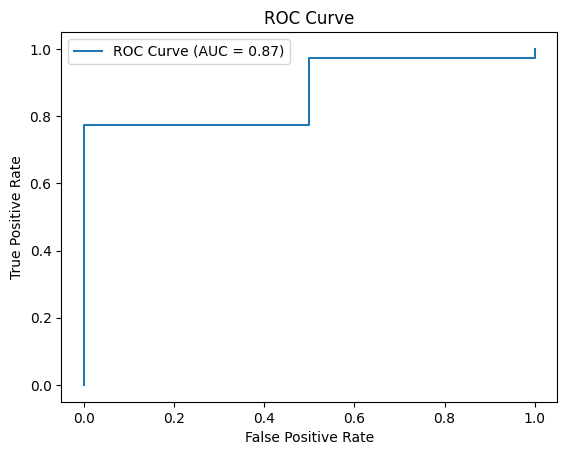

In [74]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

- How stable is the model out of sample?

- **`cross_val_score` Function:**
  - `cross_val_score(logistic_Reg, X_test, y_test, cv=5, scoring='accuracy')`: This function performs K-fold cross-validation on the logistic regression model (`logistic_Reg`) using the test set (`X_test`, `y_test`). The parameter `cv=5` specifies 5-fold cross-validation, dividing the dataset into 5 equal-sized folds for training and testing. The `scoring='accuracy'` parameter indicates that the accuracy metric will be used to evaluate the model's performance.

- **`np.mean(cv_scores)`**:
  - After cross-validation, the function returns an array of accuracy scores for each fold. `np.mean(cv_scores)` calculates the mean accuracy across all folds, providing an estimate of the model's overall accuracy.

- **Print Statement**:
  - `print("Cross-validated Accuracy:", np.mean(cv_scores))`: This statement prints the mean cross-validated accuracy score to the console, allowing you to assess the model's performance in a more robust manner than a single train-test split.

In [75]:
cv_scores = cross_val_score(logistic_Reg, X_test, y_test, cv=5, scoring='accuracy')
print("Cross-validated Accuracy:", np.mean(cv_scores))

Cross-validated Accuracy: 0.975


- Account for imbalance:
    - The dataset has an inherent imbalance in the target class (thankfully, we don't see 50% of people turning-over after six months).
        - Run a model that applies weights to compensate for the imbalance
        - Measure the AUC, accuracy, precision and recall, and plot the ROC Curve

- Run a model that applies weights to compensate for the imbalance

- **Calculate Class Weights:**
  - `total_samples = len(y_train)`: Calculates the total number of samples in the training set.
  - `class_counts = y_train.value_counts()`: Counts the number of samples for each class (0 and 1) in the training set.
  - `class_weights = {0:total_samples/(2*class_counts[0]), 1:total_samples/(2*class_counts[1])}`: Calculates class weights based on the imbalance ratio. Class 0 (negative class) is assigned a weight that is inversely proportional to its frequency in the training set, and class 1 (positive class) is similarly weighted. This ensures that the model gives more importance to the minority class during training.

- **Instantiate Logistic Regression Model with Class Weights:**
  - `logistic_Reg_2 = LogisticRegression(class_weight=class_weights)`: Instantiates a logistic regression model (`logistic_Reg_2`) with the calculated class weights.

- **Fit Model and Predict:**
  - `logistic_Reg_2.fit(X_train, y_train)`: Trains the logistic regression model on the training data with the specified class weights.
  - `y_pred_2 = logistic_Reg_2.predict(X_test)`: Predicts the target variable using the trained model on the test data.
  - `y_pred_proba_2 = logistic_Reg_2.predict_proba(X_test)[:,1]`: Predicts the probability of the positive class for each sample in the test set.

- **Evaluate Model Performance:**
  - Computes various performance metrics such as AUC, accuracy, precision, and recall using the predicted values (`y_pred_2`) and predicted probabilities (`y_pred_proba_2`).
  - Prints the AUC, accuracy score, precision, and recall to the console.
  - Performs cross-validation to evaluate the model's accuracy using the test set and prints the mean cross-validated accuracy.

This approach helps address the issue of class imbalance by adjusting the model's training process to give more weight to minority class samples, potentially improving its ability to correctly classify the minority class.

In [76]:
total_samples = len(y_train)
class_counts = y_train.value_counts()
class_weights = {0:total_samples/(2*class_counts[0]), 1:total_samples/(2*class_counts[1])}

logistic_Reg_2 = LogisticRegression(class_weight=class_weights)
logistic_Reg_2.fit(X_train,y_train)
y_pred_2 = logistic_Reg_2.predict(X_test)
y_pred_proba_2 = logistic_Reg_2.predict_proba(X_test)[:,1]

auc_2 = roc_auc_score(y_test,y_pred_proba_2)
accuracy = accuracy_score(y_test,y_pred_2)
precision = precision_score(y_test,y_pred_2)
recall = recall_score(y_test,y_pred_2)

print('AUC:',auc_2)
print('Accuracy Score:',accuracy)
print('Precision:',precision)
print('Recall:',recall)

cv_scores = cross_val_score(logistic_Reg_2,X_test,y_test,cv=5,scoring='accuracy')
print('Cross Validate - Accuracy:',np.mean(cv_scores))

AUC: 0.9133333333333333
Accuracy Score: 0.8311688311688312
Precision: 1.0
Recall: 0.8266666666666667
Cross Validate - Accuracy: 0.8558333333333333


- Plot ROC Curve

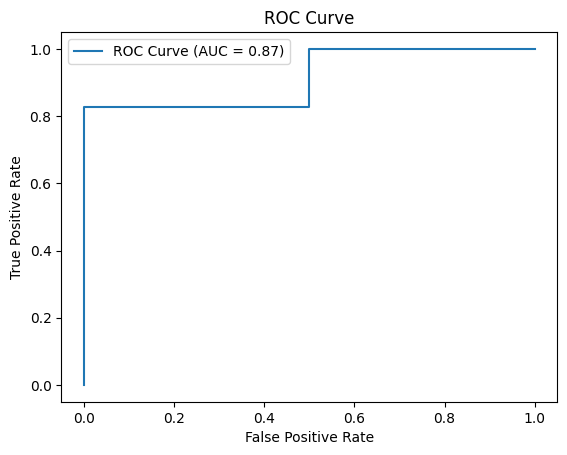

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_2)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

- Analysis for Recommendation:
    - Analysis the model
        - what are the most important features?
        - Do you believe your model is good enough to suggest that you can predict/explain turnover?
    - Recommendations
        - Do you have any specific actions to recommend to reduce turnover in the short term?
        - would you recommend LoanTronic run the survey again next year?

### Analysis the Model

- What are the most important features?

- **Compute Feature Importance:**
  - `logistic_Reg.coef_[0]`: Retrieves the coefficients of the features from the trained logistic regression model (`logistic_Reg`).

- **Create DataFrame for Feature Importance:**
  - `pd.DataFrame({'Features':X_train.columns,'Coefficient':logistic_Reg.coef_[0]})`: Creates a DataFrame (`feature_importance_1`) containing the names of the features (`Features`) and their corresponding coefficients (`Coefficient`). The coefficients represent the impact of each feature on the target variable.

- **Sort Feature Importance DataFrame:**
  - `feature_importance_1.sort_values(by='Coefficient', ascending=False)`: Sorts the DataFrame `feature_importance_1` by the coefficient values in descending order, so the features with the highest positive impact on the target variable are listed first.

- **Display Feature Importance:**
  - `print(feature_importance_1)`: Prints the DataFrame `feature_importance_1` to the console, showing the features and their coefficients.

**Interpretation:**
- Positive coefficients indicate that an increase in the corresponding feature value is associated with a higher likelihood of the positive class (employee turnover), while negative coefficients suggest the opposite.
- Features with larger absolute coefficient values have a stronger impact on the model's predictions. For example:
  - The feature `engagement` has the highest positive coefficient (1.368607), indicating that higher levels of employee engagement are associated with a higher likelihood of turnover.
  - On the other hand, features like `age_18 - 24` and `employee_id` have negative coefficients, suggesting that younger age and specific employee IDs are associated with a lower likelihood of turnover.

In [78]:
# Logisic Regression Model - without weights
feature_importance_1 = pd.DataFrame({'Features':X_train.columns,'Coefficient':logistic_Reg.coef_[0]})
feature_importance_1 = feature_importance_1.sort_values(by='Coefficient', ascending=False)
print(feature_importance_1)

                            Features  Coefficient
7                         engagement     1.368607
31              manager_satisfaction     0.980643
9                            overall     0.975015
6                         enablement     0.922361
8                         leadership     0.659956
0                         manager_id     0.583230
5                        development     0.539789
25                             sex_M     0.454178
1                          tenure_id     0.435949
3                          seniority     0.429475
22                       age_35 - 44     0.394582
14               department_Back End     0.381953
13  department_Algorithm Development     0.377644
19              location_Chicago, IL     0.375104
33                manager_avg_tenure     0.349722
30     tenure_4 to less than 6 years     0.305522
11                   time_on_the_job     0.270952
26       employment_status_Full time     0.259537
18               location_Austin, TX     0.249088


- **Compute Feature Importance:**
  - `logistic_Reg_2.coef_[0]`: Retrieves the coefficients of the features from the logistic regression model (`logistic_Reg_2`) that was trained with class weights applied.

- **Create DataFrame for Feature Importance:**
  - `pd.DataFrame({'Features':X_train.columns,'Coefficient':logistic_Reg_2.coef_[0]})`: Creates a DataFrame (`feature_importance_2`) containing the names of the features (`Features`) and their corresponding coefficients (`Coefficient`). These coefficients represent the impact of each feature on the target variable, considering the class imbalance.

- **Sort Feature Importance DataFrame:**
  - `feature_importance_2.sort_values(by='Coefficient', ascending=False)`: Sorts the DataFrame `feature_importance_2` by the coefficient values in descending order, so the features with the highest positive impact on the target variable are listed first.

- **Display Feature Importance:**
  - `print(feature_importance_2)`: Prints the DataFrame `feature_importance_2` to the console, showing the features and their coefficients.

**Interpretation:**
- These coefficients represent the impact of each feature on the likelihood of turnover, considering the class imbalance. Positive coefficients indicate that an increase in the corresponding feature value is associated with a higher likelihood of turnover, while negative coefficients suggest the opposite.
- Features with larger absolute coefficient values have a stronger impact on the model's predictions, even when considering the class imbalance. For example:
  - The feature `engagement` has the highest positive coefficient (2.851155), indicating that higher levels of employee engagement are strongly associated with a higher likelihood of turnover.
  - Conversely, features like `age_45 - 54` and `employee_id` have negative coefficients, suggesting that older age and specific employee IDs are associated with a lower likelihood of turnover.

In [79]:
# Logisic Regression Model - with weights
feature_importance_2 = pd.DataFrame({'Features':X_train.columns,'Coefficient':logistic_Reg_2.coef_[0]})
feature_importance_22 = feature_importance_2.sort_values(by='Coefficient', ascending=False)
print(feature_importance_2)

                            Features  Coefficient
0                         manager_id     1.024174
1                          tenure_id     0.571352
2                        employee_id    -1.091766
3                          seniority     1.073606
4                          alignment     0.069393
5                        development     1.472043
6                         enablement     1.708392
7                         engagement     2.851155
8                         leadership     1.188130
9                            overall     1.971425
10                     year_of_birth    -0.745771
11                   time_on_the_job     0.238138
12    department_Advanced Technology     0.011916
13  department_Algorithm Development     0.798428
14               department_Back End     0.994954
15      department_Channel Marketing     0.570263
16             department_Compliance     0.897820
17              location_Atlanta, GA     0.456986
18               location_Austin, TX     0.817889


- Do you believe your model is good enough to suggest that you can predict/explain turnover?

- Considering auc score for both the models if auc score is greater than 0.8 trying to recommend as given below.

In [80]:
# Logisic Regression Model - without weights
if auc >= 0.8:
    print("The model has good predictive power for turnover.")
else:
    print("Further improvements may be needed to enhance the model's predictive ability.")

The model has good predictive power for turnover.


In [81]:
# Logisic Regression Model - with weights
if auc_2 >= 0.8:
    print("The model has good predictive power for turnover.")
else:
    print("Further improvements may be needed to enhance the model's predictive ability.")

The model has good predictive power for turnover.


### Recommendations

- Do you have any specific actions to recommend to reduce turnover in the short term?

In [ ]:
'''  
Logistic Regression - without weights                           
                            Features  Coefficient
7                         engagement     1.368607
31              manager_satisfaction     0.980643
9                            overall     0.975015
6                         enablement     0.922361
8                         leadership     0.659956
'''

'''  
Logistic Regression - with weights                           
                            Features  Coefficient
0                         manager_id     1.024174
1                          tenure_id     0.571352
2                        employee_id    -1.091766
3                          seniority     1.073606
4                          alignment     0.069393
'''

### Recommendation on Survey

- Logistic Regression - without weights

In [ ]:
# Example recommendation:
if auc >= 0.8:
    print("Recommendation: Conducting the survey again next year could provide valuable insights for further refining strategies to reduce turnover.")
else:
    print("Recommendation: Further evaluation is needed to determine the effectiveness of the survey in predicting turnover. Conducting the survey again next year may be beneficial to gather additional data.")


Recommendation: Conducting the survey again next year could provide valuable insights for further refining strategies to reduce turnover.


- Logistic Regression - with weights

In [ ]:
# Example recommendation:
if auc_2 >= 0.8:
    print("Recommendation: Conducting the survey again next year could provide valuable insights for further refining strategies to reduce turnover.")
else:
    print("Recommendation: Further evaluation is needed to determine the effectiveness of the survey in predicting turnover. Conducting the survey again next year may be beneficial to gather additional data.")


Recommendation: Conducting the survey again next year could provide valuable insights for further refining strategies to reduce turnover.
